# Импорт библиотек

In [107]:
import numpy as np
import pandas as pd 
# Матечатические тесты
from scipy.stats import shapiro, levene, mannwhitneyu, normaltest
from tqdm.auto import tqdm
from scipy.stats import norm
try:
    import pymc as pm
except:
    !pip install pymc
    import pymc as pm
import arviz as az
# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

# Начало анализа 

Прочитаем наши данные.

In [108]:
df = pd.read_csv("C:\ForProject\AB_Testing\AB_Test_Results.csv")

In [109]:
df

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9995,1981,control,0.0
9996,502,variant,0.0
9997,9214,variant,0.0
9998,7741,control,0.0


In [110]:
def check_df(df):
    print("--------------------- Shape ---------------------")
    print(df.shape)
    print("---------------------- Types --------------------")
    print(df.dtypes)
    print("--------------------- Head ---------------------")
    print(df.head(5))
    print("--------------------- Quantiles ---------------------")
    print(df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("--------------------- Nulls ---------------------")
    print(df.isna().sum())
    print('--------------------- Uniques ---------------------')
    print(df.nunique().sum)
    print()

check_df(df)

--------------------- Shape ---------------------
(10000, 3)
---------------------- Types --------------------
USER_ID           int64
VARIANT_NAME     object
REVENUE         float64
dtype: object
--------------------- Head ---------------------
   USER_ID VARIANT_NAME  REVENUE
0      737      variant      0.0
1     2423      control      0.0
2     9411      control      0.0
3     7311      control      0.0
4     6174      variant      0.0
--------------------- Quantiles ---------------------
         0.00   0.05    0.50    0.95       0.99      1.00
USER_ID   2.0  527.9  4962.0  9488.1  9914.0100  10000.00
REVENUE   0.0    0.0     0.0     0.0     1.6609    196.01
--------------------- Nulls ---------------------
USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64
--------------------- Uniques ---------------------
<bound method NDFrame._add_numeric_operations.<locals>.sum of USER_ID         6324
VARIANT_NAME       2
REVENUE          101
dtype: int64>



Данные уже очищены и готовы для анализа. Глядя на квантили можно сказать, что данные распределены ненормально. Следует посмотреть на визуализацию и провести тесты на проверку нормальности распределения.

In [111]:
df_paying = df.loc[df['REVENUE'] > 0]

In [112]:
variant = df_paying.loc[df['VARIANT_NAME'] == 'variant']
control = df_paying.loc[df['VARIANT_NAME'] == 'control']

<AxesSubplot:xlabel='REVENUE', ylabel='Count'>

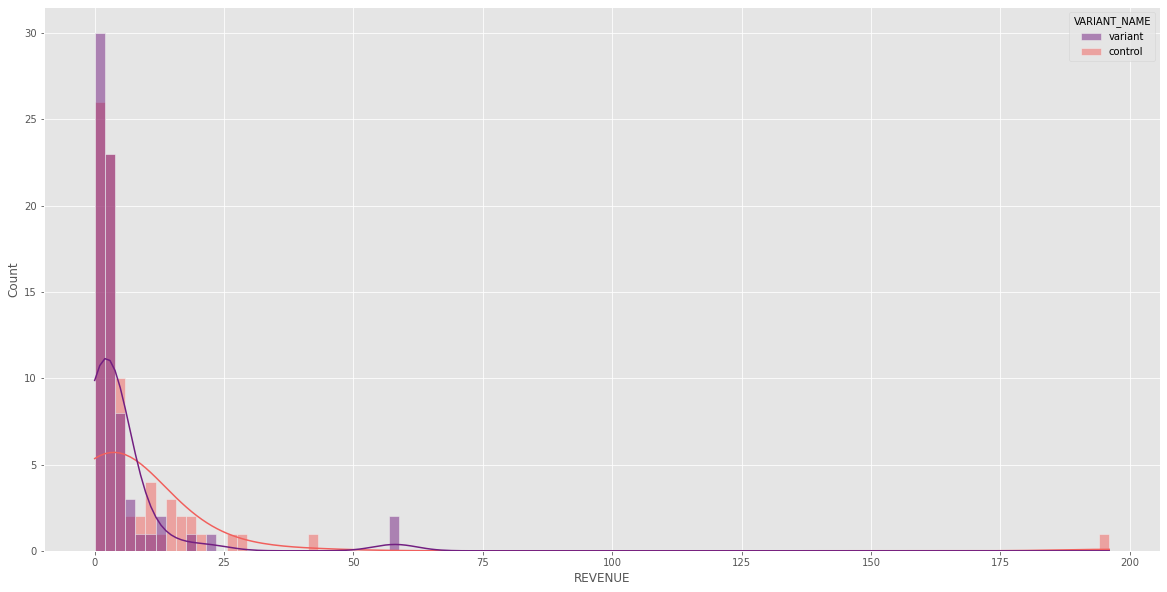

In [113]:
plt.figure(figsize=(20, 10))
sns.histplot(
    data = df.loc[(df["REVENUE"] !=0) & (df["REVENUE"] < 200)],
    x = 'REVENUE',
    hue = 'VARIANT_NAME',
    kde = True,
    bins = 100,
    palette = 'magma'
)

Мы можем увидеть, что в контрольной группе была совершенна единственная покупка на высокое значение. Возможно оно повлияет на конечный результат, так как является слишком отличным от других наших значений. Лучше будет его убрать

In [114]:
df['REVENUE'].sort_values()

0         0.00
6635      0.00
6636      0.00
6637      0.00
6638      0.00
         ...  
8168     29.32
9421     41.53
7642     57.46
6447     58.63
1437    196.01
Name: REVENUE, Length: 10000, dtype: float64

In [115]:
df = df[df.REVENUE != 196.01]

In [116]:
df['REVENUE'].sort_values()

0        0.00
6636     0.00
6637     0.00
6638     0.00
6639     0.00
        ...  
9125    25.98
8168    29.32
9421    41.53
7642    57.46
6447    58.63
Name: REVENUE, Length: 9999, dtype: float64

<AxesSubplot:xlabel='REVENUE', ylabel='Count'>

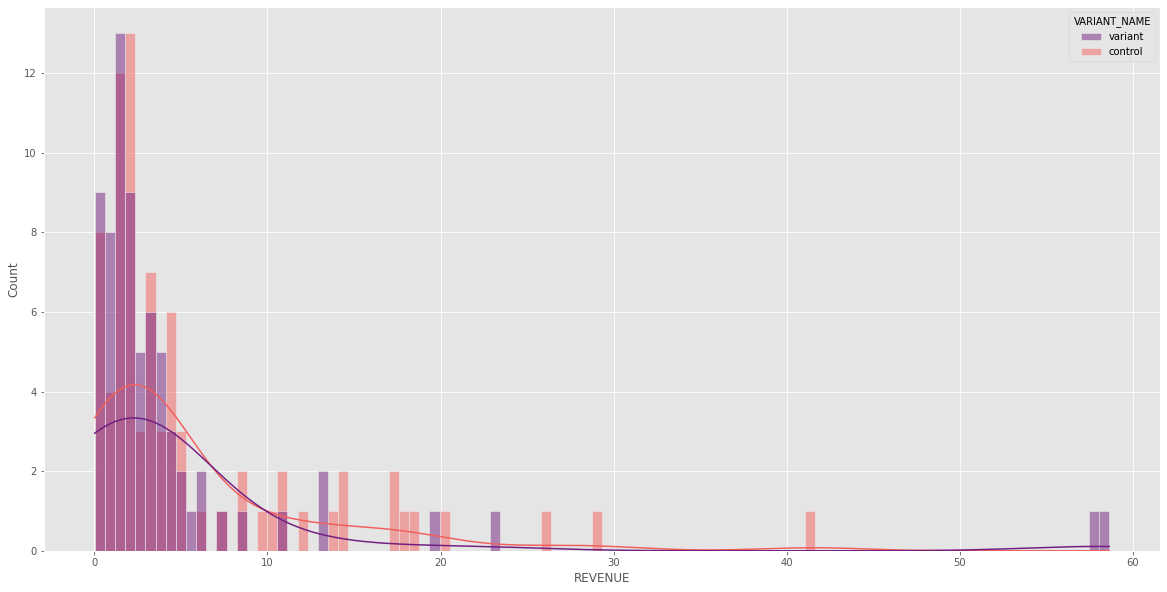

In [117]:
plt.figure(figsize=(20, 10))
sns.histplot(
    data = df.loc[(df["REVENUE"] !=0)],
    x = 'REVENUE',
    hue = 'VARIANT_NAME',
    kde = True,
    bins = 100,
    palette = 'magma'
)

Распределение по 2 группам выглядит довольно схожим. Далее посмотрим на статистики обоих групп.

In [118]:
df.groupby("VARIANT_NAME").agg(
    mean_all=("REVENUE", "mean"),
    std_all=("REVENUE", "std"),
    n_in_group=("REVENUE", "count"),
    mean_paying=("REVENUE", lambda x: np.mean(x[x!=0])),
    std_paying=("REVENUE", lambda x: np.std(x[x!=0])),
    n_paying=("REVENUE", lambda x: sum(x != 0)),
    normal_test=("REVENUE", lambda x: normaltest(x)[1])
)

,mean_all,std_all,n_in_group,mean_paying,std_paying,n_paying,normal_test
VARIANT_NAME,,,,,,,
control,0.089703,1.159256,4983,5.658101,7.296748,79,0.0
variant,0.070070,1.314802,5016,4.881528,9.844885,72,0.0


In [121]:
shapiro(control.REVENUE)

ShapiroResult(statistic=0.2808055877685547, pvalue=6.5033072107817044e-18)

In [122]:
shapiro(variant.REVENUE)

ShapiroResult(statistic=0.41705214977264404, pvalue=2.1140220769002042e-15)

Из всей имеющейся информации видим, что распределения действительно являются ненормальными. Значения средних отличаются, но пока не понятно на сколько эти значения статистически значимы. Столбец "normal_test" проверяет нулевую гипотезу о том, что выборки взяты из нормального распределения. Мы можем видеть, что нулевая гипотеза отвергается для обеих наших групп.

# Проведение тестов

В данном случае мы не можем использовать t-test, потому что распределения являются ненормальными, в данном случае это может привести к неправильным выводам. В любом случае нужно проверить однородность дисперсий, сделать это можно либо с помощью теста Левена, либо тест Бартлетта. Для начала проведем тест Левена

H0: Дисперсии однородны.
H1: Дисперсии не являются однородными.

p < 0,05 H0 ОТКЛОНЕНО,
p > 0,05 H0 НЕ МОЖЕТ БЫТЬ ОТКЛОНЕНО.

In [123]:
levene(control["REVENUE"], variant["REVENUE"])

LeveneResult(statistic=1.0050345981535496, pvalue=0.31770982736677544)

P-value в данном случае > 0.05, это означает, что у нас недостаточно оснований для отклонения нулевой гипотезы, что дисперсии однородны.

# Манна-Уитни

In [124]:
mannwhitneyu(control["REVENUE"], variant["REVENUE"])

MannwhitneyuResult(statistic=3356.0, pvalue=0.07924299810603061)

По данному тесту мы не можем отклонить нулевую гипотезу, так как p value > 0.05. Из этого следует, что у нас нет статистически значимых отличий между двумя группами. Но чтобы удостовериться мы так 

# Байесовское моделирование

In [125]:
grp_idx, grp_names = pd.factorize(df_paying["VARIANT_NAME"])
# variant -> 0
# control -> 1

In [126]:
coords = {
    "groups":grp_names
}


with pm.Model(coords=coords) as model:

    hypermu=pm.Normal("hyppermu", mu=6.5, sigma=10) # hypermu with grouped mean as mu
    mu=pm.Normal("mu", mu=hypermu, sigma=2, dims="groups")
    sigma=pm.HalfNormal("sigma", sigma=10, dims="groups")

    mean_difference = pm.Deterministic("variant - control", mu[0] -  mu[1])

    y = pm.Normal("obs",mu=mu[grp_idx], sigma=sigma[grp_idx], observed=df_paying["REVENUE"])

    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [hyppermu, mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 103 seconds.


array([[<AxesSubplot:title={'center':'hyppermu'}>,
        <AxesSubplot:title={'center':'hyppermu'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'variant - control'}>,
        <AxesSubplot:title={'center':'variant - control'}>]], dtype=object)

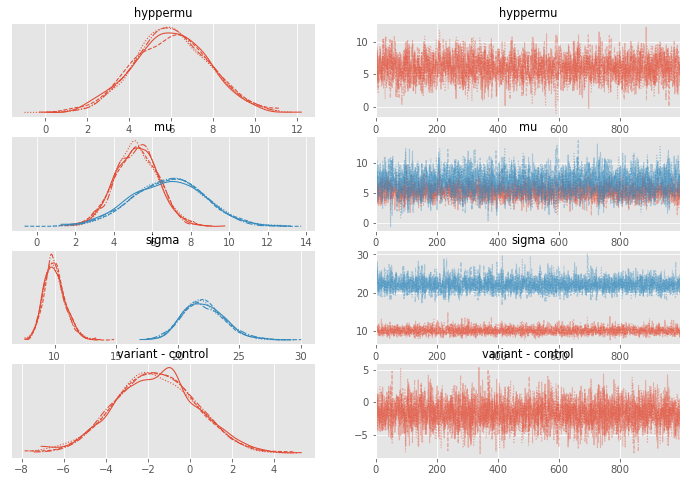

In [127]:
az.plot_trace(trace)

Мы получаем распределение вероятностей для параметров распределений выборки. Получаем реальные вероятности для среднего значения variant/control группы и различий в среднем. Мы можем видеть, что вполне вероятно, что контрольная группа имеет более высокое среднее значение.

array([[<AxesSubplot:title={'center':'hyppermu'}>,
        <AxesSubplot:title={'center':'mu\nvariant'}>,
        <AxesSubplot:title={'center':'mu\ncontrol'}>],
       [<AxesSubplot:title={'center':'sigma\nvariant'}>,
        <AxesSubplot:title={'center':'sigma\ncontrol'}>,
        <AxesSubplot:title={'center':'variant - control'}>]], dtype=object)

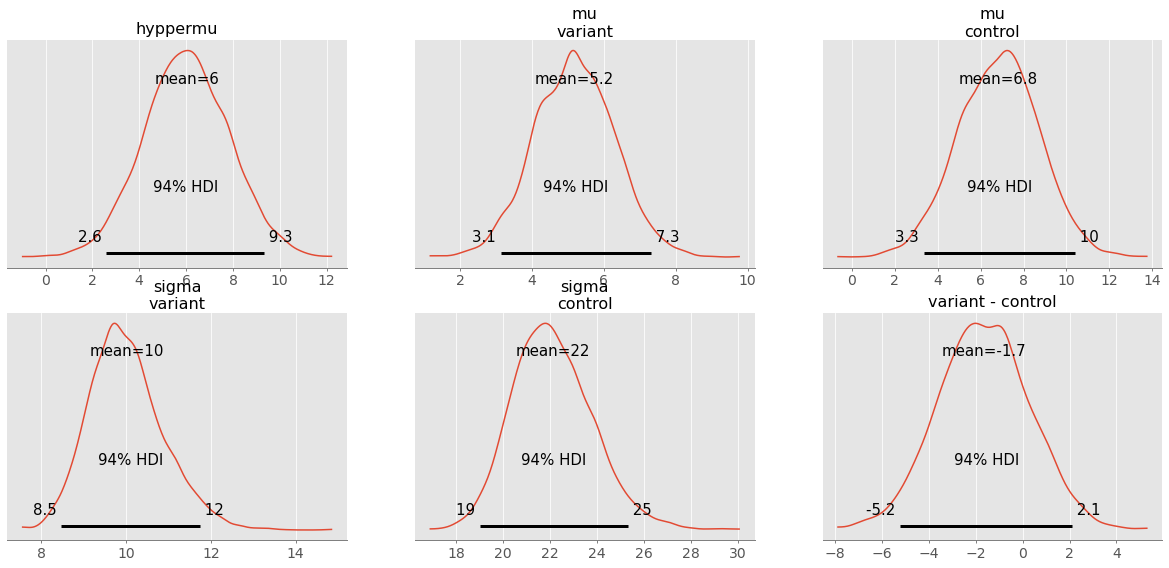

In [128]:
az.plot_posterior(trace)

Этот график показывает, что 94% распределения средних различий лежит между -5,3 и 2,3, что указывает на высокую вероятность того, что разница на самом деле отрицательная и что контрольная группа имеет более высокое среднее значение.

# Бутстрап

In [ ]:
Допустим, что наши выборки являются репрезентацей генеральной совокупности. Следовательно мы сможем провести бустрап.

In [130]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

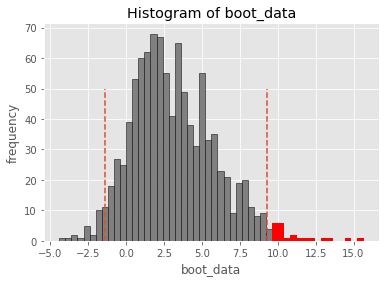

{'boot_data': [3.62175,
  6.542124999999999,
  5.4085,
  9.10175,
  1.0462500000000001,
  7.0817499999999995,
  2.1858750000000002,
  1.4238750000000002,
  5.426375,
  2.609375,
  0.6307499999999999,
  0.5366250000000001,
  -1.3087500000000003,
  5.11675,
  3.50575,
  -0.874125,
  0.748,
  1.9796250000000004,
  6.5798749999999995,
  4.27525,
  1.589,
  1.180125,
  3.7927499999999994,
  3.3751250000000006,
  5.143249999999999,
  5.336125,
  1.8155000000000001,
  1.7345,
  5.084625,
  0.5942499999999995,
  6.661125,
  1.69725,
  3.1307500000000004,
  3.4007499999999995,
  4.0045,
  1.2732500000000004,
  4.9350000000000005,
  1.9787500000000002,
  3.52275,
  1.1832500000000004,
  1.877125,
  5.7415,
  0.61975,
  4.069999999999999,
  1.3785,
  1.585375,
  1.813625,
  2.428375,
  1.9870000000000005,
  5.294375,
  0.3613750000000001,
  1.2676249999999998,
  3.3129999999999997,
  7.870124999999999,
  1.9735,
  0.730875,
  8.497,
  0.5526250000000001,
  5.719375,
  5.35225,
  3.806624999999999

In [134]:
get_bootstrap(
    control.REVENUE, # числовые значения первой выборки
    variant.REVENUE, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

  0%|          | 0/1000 [00:00<?, ?it/s]

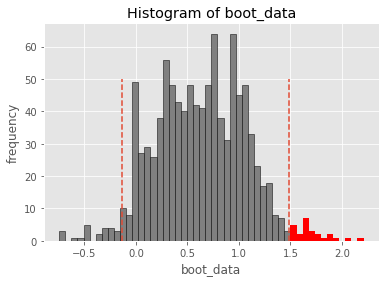

{'boot_data': [0.2749999999999999,
  1.045,
  0.32499999999999996,
  0.815,
  0.3350000000000001,
  0.77,
  0.275,
  0.040000000000000036,
  0.3350000000000004,
  -0.08499999999999996,
  0.6149999999999999,
  0.835,
  0.050000000000000266,
  2.21,
  1.17,
  0.97,
  0.6450000000000001,
  1.72,
  0.53,
  1.04,
  0.8800000000000002,
  0.7350000000000001,
  0.605,
  0.515,
  0.030000000000000027,
  1.0550000000000002,
  0.685,
  0.25,
  0.5549999999999999,
  0.8600000000000004,
  -0.5150000000000001,
  0.5900000000000001,
  0.32,
  0.7899999999999997,
  1.3049999999999997,
  1.365,
  1.0399999999999998,
  0.07000000000000006,
  0.735,
  0.9149999999999999,
  0.19499999999999995,
  0.9099999999999999,
  0.275,
  0.0,
  0.37999999999999995,
  1.52,
  0.4300000000000001,
  1.2449999999999999,
  0.72,
  0.45,
  0.9950000000000001,
  0.7450000000000001,
  0.8700000000000001,
  0.495,
  0.7250000000000004,
  0.45500000000000007,
  0.14000000000000007,
  0.9599999999999999,
  0.004999999999999893

In [137]:
get_bootstrap(
    control.REVENUE, # числовые значения первой выборки
    variant.REVENUE, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

В обоих случая доверительный интервал для разницы медиан и средних включает 0. Это означает мадианы и средние статистически не различаются